##Предисловие
Изначально данный ноутбук был написан для кластеризации текстовых данных (в нашем случае диалогов), чтобы в последствии разметить им данные. Но пообщавшись с опытными МЛ-инжинерами мы пришли к тому, что проще разметить данные через толоку и обучить берт (можно и что-то другое) уже на размеченных данных

Ниже представлен код для склеивания сообщений в диалоги и pre-processing данных.

p\s к сожалению, мне не посчастиливилось застать размеченные данные чтобы потренировать bert, но все нужные ссылки я оставил в тг для этого. 

- если возникнут какие-то вопросы, пиши в тг @Boro02

In [177]:
import pandas as pd
import re
import numpy as np
import string
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [178]:
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict,Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string
nltk.download('stopwords')
stop=set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [179]:
df = pd.read_excel('dialogs_2.xlsx')

In [180]:
df.head()

,Тикет_ID,ID_Клиента,Создано,text
0,97673249,23178555,2021-09-03,"Здравствуйте, MARGARITA! Выберите категорию об..."
1,97673249,23178555,2021-09-03,23178555-0020
2,97673249,23178555,2021-09-03,Я передал вопрос сотруднику службы поддержки. ...
3,97673249,23178555,2021-09-03,"Маргарита, спасибо за ожидание. Продавец доста..."
4,97994499,71861005,2021-09-06,"Здравствуйте, Олег! Выберите категорию обращения."


In [181]:
new_df = df.groupby(['Тикет_ID','ID_Клиента','Создано'])['text'].apply(lambda x: "%s" % ' // '.join(x)) # группирую по всему, кроме текста

In [182]:
df.groupby('Тикет_ID')['ID_Клиента','Создано']

In [183]:
new_df

Тикет_ID  ID_Клиента  Создано   
97418784  73933164    2021-09-01    Где мой заказ? // Вы имеете в виду заказ 73933...
97422129  73664365    2021-09-01    73664365-0003 // Когда он будет? // Я передал ...
97423399  42110626    2021-09-01    42110626-0008 // Я передал вопрос сотруднику с...
97423522  42211530    2021-09-01    Здравствуйте, Елена! Выберите категорию обраще...
97423782  44539777    2021-09-01    Здравствуйте, Владислав! Выберите категорию об...
                                                          ...                        
98104418  254814      2021-09-06    00254814-0053 // Я передал вопрос сотруднику с...
98104492  55068836    2021-09-06    Ранее вы оставляли отзыв о товаре "Одеяло Иван...
98105394  49969305    2021-09-06    Здравствуйте, Владимир! Выберите категорию обр...
98106909  46335211    2021-09-06    Где мой заказ? // Выберите номер заказа, котор...
98114321  44739213    2021-09-06    Здравствуйте, Александр! Выберите категорию об...
Name: text, Length: 2

In [184]:
new_df.iloc[8]

'Здравствуйте, Мария! Выберите категорию обращения. // Где мой заказ? // Вы имеете в виду заказ 20279744-0029? // Да // Я передал вопрос сотруднику службы поддержки. Он вернется с ответом в течение 9 минут, вам придёт уведомление. // Мария, спасибо за ожидание. Понимаю вас и ваше волнение. Но прошу вас не переживать. Я проверил информацию по вашему вопросу. Ваш заказ уже приближается к вашему городу. Мы доставим его сегодня до 00:00 включительно в пункт выдачи по адресу Россия, Московская обл., Фрязино, ул. Мира, 29. О его прибытии уведомим вас по почте. Так же придёт Push-уведомление в приложении. Если появятся дополнительные вопросы, напишите в чат. Мы во всём разберёмся и обязательно поможем вам. Хорошего дня🌸'

Как видим, смс склеились в диалоги
# теперь почистим немного наши данные 

In [186]:
new_df = new_df.reset_index(['Тикет_ID','ID_Клиента','Создано'])

In [187]:
new_df['text'] = new_df['text'].apply(lambda x: re.sub("\n"," ",x))

In [188]:
new_df['text'] = new_df['text'].apply(lambda x: re.sub("//","",x))

In [189]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F" 
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002500-\U00002BEF" 
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f" 
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)
new_df['text']=new_df['text'].apply(lambda x : remove_emojis(x))

In [190]:
def remove_URL(text):
    url = re.compile(r'http\S+')
    return url.sub(r'',text)

new_df['text']=new_df['text'].apply(lambda x : remove_URL(x))

In [192]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
new_df['text']=new_df['text'].apply(lambda x : remove_html(x))

In [193]:
def lower(text):
    low_text= text.lower()
    return low_text
new_df['text'] = new_df['text'].apply(lambda x : lower(x))

In [194]:
def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

new_df['text']=new_df['text'].apply(lambda x : clean_numbers(x))

In [195]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

new_df['text']=new_df['text'].apply(lambda x : remove_punct(x))

In [196]:
new_df.drop(['Тикет_ID', 'ID_Клиента', 'Создано'], axis=1, inplace=True)

In [197]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings 
warnings.filterwarnings('ignore')

In [198]:
import wordcloud 

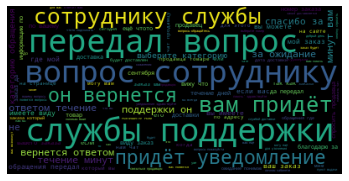

In [199]:
text = new_df['text'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
def create_corpus():
    corpus=[]
    
    for x in new_df['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 10 artists>

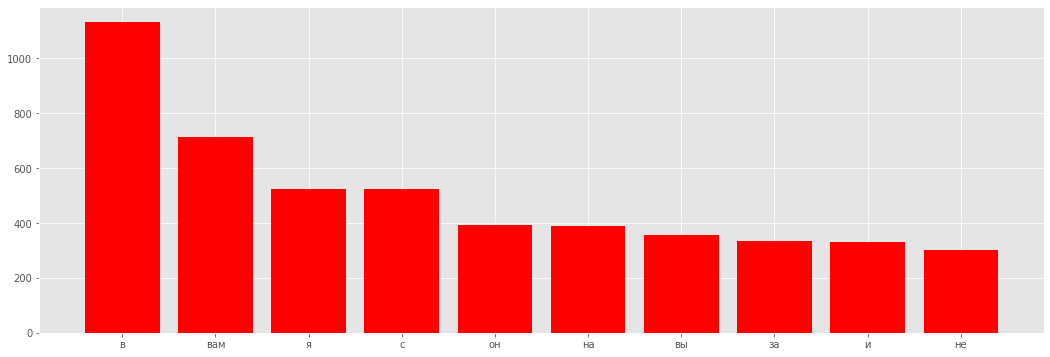

In [ ]:
from collections import defaultdict,Counter

corpus=create_corpus()

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color="red")

In [ ]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

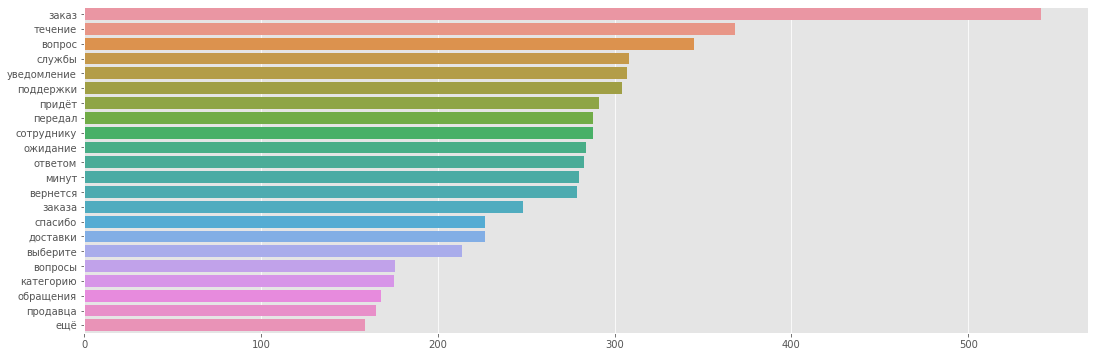

In [ ]:
import seaborn as sns
sns.barplot(x=y,y=x)

In [ ]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

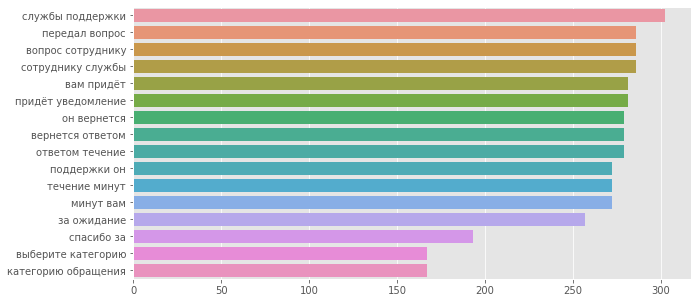

In [ ]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(new_df['text'])[:16]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

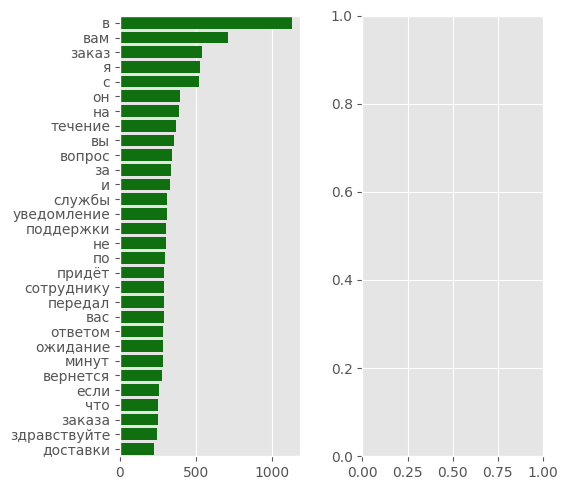

In [ ]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 30


unigram = defaultdict(int)


# Униграмы
for tweet in new_df['text']:
    for word in generate_ngrams(tweet):
        unigram[word] += 1
        
      
        
df_unigram = pd.DataFrame(sorted(unigram.items(), key=lambda x: x[1])[::-1])


fig, axes = plt.subplots(ncols=2, figsize=(5, 5), dpi=100)
plt.tight_layout()

sns.barplot(y=df_unigram[0].values[:N], x=df_unigram[1].values[:N], ax=axes[0], color='green')



plt.show()

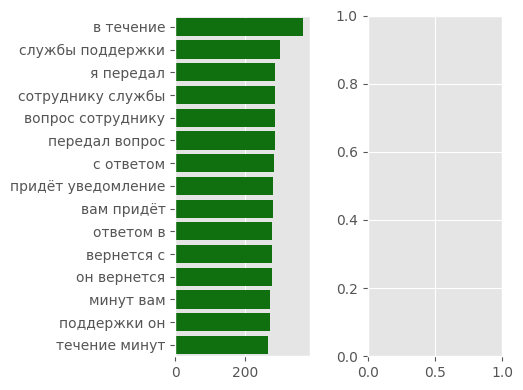

In [ ]:
N = 15

# Bigrams
positive_bigrams = defaultdict(int)



for tweet in new_df['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        positive_bigrams[word] += 1
        
      
        
df_positive_bigrams = pd.DataFrame(sorted(positive_bigrams.items(), key=lambda x: x[1])[::-1])


fig, axes = plt.subplots(ncols=2, figsize=(4, 4), dpi=100)
plt.tight_layout()

sns.barplot(y=df_positive_bigrams[0].values[:N], x=df_positive_bigrams[1].values[:N], ax=axes[0], color='green')




plt.show()

Нужно заказать клининг :)

Далее разбиваем диалоги на токены и создаем лемматизацию для приведения всех сообщений в именительный падеж, чтобы "красивый" и "красивая" не отличались друг от друга

#Токенизация и лемматизация (если планируется использовать не BERT)

In [ ]:
df2 = new_df.copy()

In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.6 MB/s 
     |████████████████████████████████| 8.2 MB 11.1 MB/s 


In [ ]:
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
from pymorphy2 import MorphAnalyzer



def tokenize_n_normalize(sent, pat=r"(?u)\b\w\w+\b", morph=MorphAnalyzer()):
    return [morph.parse(tok)[0].normal_form 
            for tok in regexp_tokenize(sent, pat)]



df2["text"] = df2["text"].map(lambda x: " ".join(tokenize_n_normalize(x)))

#Токенизация (если планируется использовать BERT)

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
new_df['text'] = new_df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)


#После отчистки данных от мусора и анализа n_grams можно создать собственный список стоп слов и заджоинить его с небольшим импортированным, чтобы убрать шумовые слова

Поскольку используя TF_IDF можно выкинуть нужные нам слова, например заказ - информативное слово, которое на самом деле имеет большую предсказательную силу, мы воспользуемся классическим выбрасыванием стоп слов - списком 


In [ ]:
custom_stop_phrases = ['здравствуйте', 'спасибо за ожидание', 'хорошего дня', 'добрый день', 
                       'всего доброго', 'будем рады помочь', 'выберите категорию обращения', 'обязательно решим ваш вопрос'
                       ,'дождались ответа ']
for i in custom_stop_phrases:
    stop.add(i)

In [ ]:
STOPWORDS = set(stopwords.words('russian'))
# функция для удаления стоп-слов
def stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop])
df2["text"] = df2["text"].apply(stopwords)

##Здесь лежит пример реализации сабсемплинга, может помочь при обучении

In [ ]:
! wget https://raw.githubusercontent.com/hse-ds/iad-deep-learning/master/2021/seminars/sem07/utils.py

--2021-12-06 10:36:16--  https://raw.githubusercontent.com/hse-ds/iad-deep-learning/master/2021/seminars/sem07/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1516 (1.5K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   1.48K  --.-KB/s    in 0s      

2021-12-06 10:36:17 (19.0 MB/s) - ‘utils.py’ saved [1516/1516]



In [ ]:
# new_df.drop(['Тикет_ID', 'ID_Клиента', 'Создано'], axis=1, inplace=True)
new_df = new_df.astype(str)

In [ ]:
texts = new_df['text'].to_numpy()
np.savetxt('dialogs_utf8.txt', texts, delimiter='\n', fmt='%s', encoding='utf-8')

In [ ]:
# чтение файла     
with open('dialogs_utf8.txt') as f:
    text = f.read()

# пример
print(text[:1000])

где мой заказ  вы имеете в виду заказ   да  я передал вопрос сотруднику службы поддержки извините сейчас обращений очень много поэтому время ответа может составить до 3 часов мы пришлём вам уведомление и обязательно решим ваш вопрос  ответы на самые частые вопросы можно найти в помощи httpsdocsozonrucommon  здравствуйте сергей спасибо за ожидание  судя по данным трекномера  августа ваш заказ был в москве значит сегодня уже должен приехать к вам в город  за более подробной информацией рекомендую вам обратиться в транспортную компанию сдек они смогут более точно сообщить вам о местоположении заказа и сроки доставки  телефон сдек   если у вас появятся вопросы пожалуйста пишите нам 
  когда он будет  я передал вопрос сотруднику службы поддержки он вернется с ответом в течение  минут вам придёт уведомление  татьяна спасибо вам за ожидание ответа к сожалению товары не доставлены в обещанную дату для уточнения новой даты доставки обратитесь в транспортную компанию по номеру  или свяжитесь с п

In [ ]:
import utils

words = utils.preprocess(text)
print(words[:30])

['где', 'мой', 'заказ', 'вы', 'имеете', 'в', 'виду', 'заказ', 'да', 'я', 'передал', 'вопрос', 'сотруднику', 'службы', 'поддержки', 'извините', 'сейчас', 'обращений', 'очень', 'много', 'поэтому', 'время', 'ответа', 'может', 'составить', 'до', '3', 'часов', 'мы', 'пришлём']


In [ ]:
# немного статистики вкинем
print(f"Total words in text: {len(words)}")
print(f"Unique words: {len(set(words))}")

Total words in text: 25883
Unique words: 582


In [ ]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[57, 62, 2, 8, 55, 0, 54, 2, 79, 3, 18, 9, 19, 12, 14, 156, 87, 209, 139, 199, 102, 80, 113, 221, 525, 65, 93, 272, 36, 257]


#### Subsampling

Часто встречающиеся слова, такие как «здраствуйте», «добрый» и «уточняю», не обеспечивают особого контекста для близлежащих слов. 
Если мы отбросим некоторые из них, мы сможем удалить часть шума из наших данных и взамен получить более быстрое обучение и лучшее представление. 
Этот процесс иногда называют субдискретизацией. 
Для каждого слова $w_i$ в обучающем наборе мы отбрасываем его с вероятностью, равной

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

где $t$ - пороговый параметр, а $f(w_i)$ - частота слова $w_i$ в общем наборе данных.

$$ P(0) = 1 - \sqrt{\frac{1*10^{-5}}{10^6/(16*10^6)}} = 0.98735 $$

<br>


In [ ]:
import random
from collections import Counter

import numpy as np
from tqdm.auto import tqdm, trange


threshold = 1e-5
word_counts = Counter(int_words)  # словарь с количеством появлений каждого слова 
print(f"42-th word appears in the text {word_counts[42]} times")  

# выбросим несколько слов как завещал отец сабсемплинга
# создадим новый лист для обучения

train_words = []

for int_w in tqdm(int_words):
    if random.random() < (threshold / (word_counts[int_w] / len(int_words))) ** 0.5:
        train_words.append(int_w)
    else:
        continue

42-th word appears in the text 150 times


  0%|          | 0/25883 [00:00<?, ?it/s]

In [ ]:
print(int_words[:15]) #что было зизначально
print(train_words[:15]) #что теперь 


[57, 62, 2, 8, 55, 0, 54, 2, 79, 3, 18, 9, 19, 12, 14]
[55, 102, 40, 258, 140, 528, 31, 7, 23, 0, 1, 253, 13, 19, 10]


#Попытка обучить K-Means для кластеризации 
###offtop - он плох для наших данных

In [ ]:
new_df['text'][8]

'здравствуйте мария выберите категорию обращения  где мой заказ  вы имеете в виду заказ   да  я передал вопрос сотруднику службы поддержки он вернется с ответом в течение 9 минут вам придёт уведомление  мария спасибо за ожидание понимаю вас и ваше волнение но прошу вас не переживать я проверил информацию по вашему вопросу ваш заказ уже приближается к вашему городу мы доставим его сегодня до  включительно в пункт выдачи по адресу россия московская обл фрязино ул мира  о его прибытии уведомим вас по почте так же придёт pushуведомление в приложении если появятся дополнительные вопросы напишите в чат мы во всём разберёмся и обязательно поможем вам хорошего дня🌸'

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [ ]:
text = new_df['text'].values
max_features = 2**12

X = vectorize(text, max_features)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(273, 221)

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

In [ ]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# прогоняем к средних для разных к
distortions = []
K = range(2, 30)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

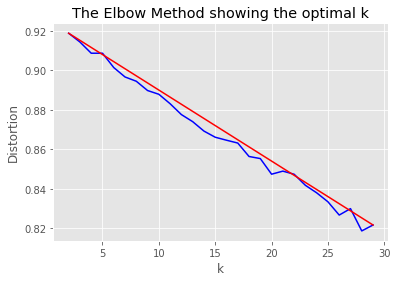

In [ ]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# посмотрим на локоть которого нет
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
k = 4 #тут было изначально известно 
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
new_df['y'] = y_pred

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=50)  
X_embedded = tsne.fit_transform(X.toarray())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 273 samples in 0.001s...
[t-SNE] Computed neighbors for 273 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 273 / 273
[t-SNE] Mean sigma: 0.301426
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.148315
[t-SNE] KL divergence after 1000 iterations: 0.940203


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


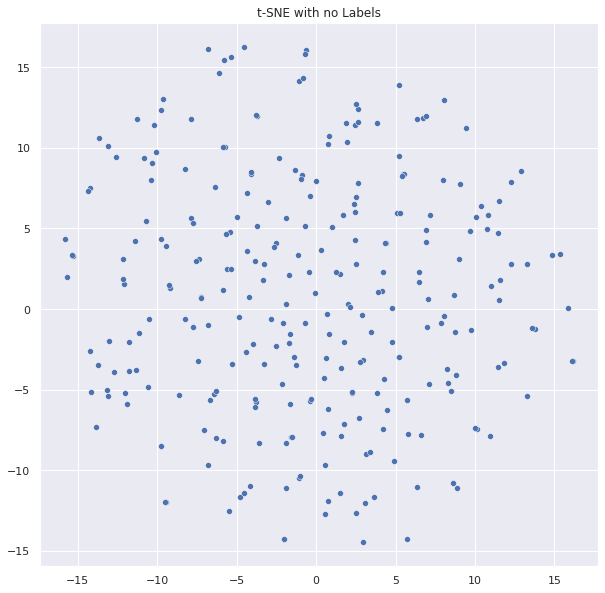

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns


sns.set(rc={'figure.figsize':(10,10)})


palette = sns.color_palette("bright", 1)


sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


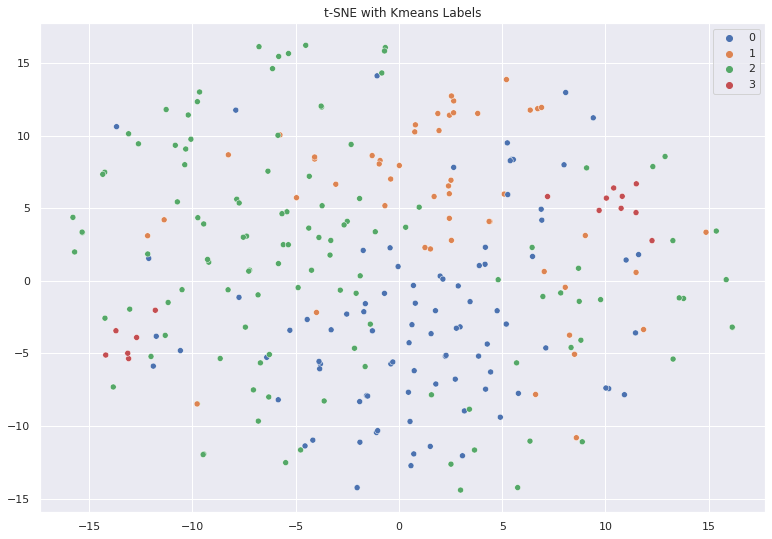

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(13,9)})


sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette='deep')

plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

In [ ]:
# text = new_df['text'].to_numpy()
# np.savetxt('dialogs_utf8.txt', text, delimiter='\n', fmt='%s', encoding='utf-8')

# from google.colab import files

# new_df.to_excel('dialog_text_j.xlsx', encoding='utf-8') 
# files.download('dialog_text_j.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Основные задачи препроцессинга
- выкидывание редких и часто встречаемых слов
- чистка от чисел, эмоджи, ссылок и прочего гавна
- стемматизация 
- лематизация 
- разбиение на токены 

- провести TF-IDF
- Bag of words 
- stop words 

#Возможные реализации
- Bert (attention is all you need)
можно использовать для эмбедингов
- robust text clustering algorithm
- DBSCAN 
- K-nn (не подходит в виду того, что он хорошо работает, если все кластеры одинаковой  и "круглой" формы, у нас такого не наблюдается ) 

#интересно
- есть озоновская толока 

In [ ]:
class Porter:
	PERFECTIVEGROUND =  re.compile(u"((ив|ивши|ившись|ыв|ывши|ывшись)|((?<=[ая])(в|вши|вшись)))$")
	REFLEXIVE = re.compile(u"(с[яь])$")
	ADJECTIVE = re.compile(u"(ее|ие|ые|ое|ими|ыми|ей|ий|ый|ой|ем|им|ым|ом|его|ого|ему|ому|их|ых|ую|юю|ая|яя|ою|ею)$")
	PARTICIPLE = re.compile(u"((ивш|ывш|ующ)|((?<=[ая])(ем|нн|вш|ющ|щ)))$")
	VERB = re.compile(u"((ила|ыла|ена|ейте|уйте|ите|или|ыли|ей|уй|ил|ыл|им|ым|ен|ило|ыло|ено|ят|ует|уют|ит|ыт|ены|ить|ыть|ишь|ую|ю)|((?<=[ая])(ла|на|ете|йте|ли|й|л|ем|н|ло|но|ет|ют|ны|ть|ешь|нно)))$")
	NOUN = re.compile(u"(а|ев|ов|ие|ье|е|иями|ями|ами|еи|ии|и|ией|ей|ой|ий|й|иям|ям|ием|ем|ам|ом|о|у|ах|иях|ях|ы|ь|ию|ью|ю|ия|ья|я)$")
	RVRE = re.compile(u"^(.*?[аеиоуыэюя])(.*)$")
	DERIVATIONAL = re.compile(u".*[^аеиоуыэюя]+[аеиоуыэюя].*ость?$")
	DER = re.compile(u"ость?$")
	SUPERLATIVE = re.compile(u"(ейше|ейш)$")
	I = re.compile(u"и$")
	P = re.compile(u"ь$")
	NN = re.compile(u"нн$")

	def stem(word):
		word = word.lower()
		word = word.replace(u'ё', u'е')
		m = re.match(Porter.RVRE, word)
		if m and m.groups():
			pre = m.group(1)
			rv = m.group(2)
			temp = Porter.PERFECTIVEGROUND.sub('', rv, 1)
			if temp == rv:
				rv = Porter.REFLEXIVE.sub('', rv, 1)
				temp = Porter.ADJECTIVE.sub('', rv, 1)
				if temp != rv:
					rv = temp
					rv = Porter.PARTICIPLE.sub('', rv, 1)
				else:
					temp = Porter.VERB.sub('', rv, 1)
					if temp == rv:
						rv = Porter.NOUN.sub('', rv, 1)
					else:
						rv = temp
			else:
				rv = temp
			
			rv = Porter.I.sub('', rv, 1)

			if re.match(Porter.DERIVATIONAL, rv):
				rv = Porter.DER.sub('', rv, 1)

			temp = Porter.P.sub('', rv, 1)
			if temp == rv:
				rv = Porter.SUPERLATIVE.sub('', rv, 1)
				rv = Porter.NN.sub(u'н', rv, 1)
			else:
				rv = temp
			word = pre+rv
		return word
	stem=staticmethod(stem)
